In [1]:
# import libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [26]:
def heatmap(data, ax=None, **kwargs):
    '''
    Create a heatmap from a numpy array and two lists of labels.
    '''

    if ax is None:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

    return im

In [3]:
# class of points in the grid
class point:
    def __init__(self, x, y):
        self.x = x        # x coordinates
        self.y = y        # y coordinates
        self.id = -1      # set initial cell ID to -1
        self.free_neighbors = []   # list of neighbor points that are not assigned a cell ID yet
        self.neighbors = []        # list of neighbor points
        
# class of cells
class cell:
    def __init__(self, id):
        self.id = id          # cell ID
        self.points = []      # list of grid points within the cell
        self.neighbors = []   # list of neighbor cells - duplicate allowed

In [4]:
# parameters

# dimensions of the grid
Xdim = 140      # x dimension
Ydim = 140      # y dimension
numPoints = Xdim * Ydim   # total number of points

# dimensions regarding the total number of cells
cellDim = 28            # one fifth of the point dimension
numCells = cellDim**2   # total number of cells

maxCellSize = 40   # max number of grid points a cell can occupy

In [5]:
# 2D grid array containing all point objects
allPoints = np.empty((Xdim, Ydim), dtype=object)

# assign points to allPoints
for i in range(0, Xdim):
    for j in range(0, Ydim):
        # Make a new point using x coords and y coords
        newPoint = point(x=i, y=j)
        allPoints[i, j] = newPoint   # store the new point in allPoints
        
# initialize free neighbors for every point in allPoints
for i in range(0, Xdim):
    for j in range(0, Ydim):
        newPoint = allPoints[i, j]
        if i + 1 < Xdim:   # if the newPoint is not the right-most point in the grid
            # find neighbor on the right side and append to neighbors list
            newPoint.free_neighbors.append(allPoints[i+1, j])
            newPoint.neighbors.append(allPoints[i+1, j])
        if i - 1 >= 0:   # if the newPoint is not the left-most point in the grid
            # find neighbor on the left side and append to neighbors list
            newPoint.free_neighbors.append(allPoints[i-1, j])
            newPoint.neighbors.append(allPoints[i-1, j])
        if j + 1 < Ydim:   # if the newPoint is not the upper-most point in the grid
            # find neighbor on the upper side and append to neighbors list
            newPoint.free_neighbors.append(allPoints[i, j+1])
            newPoint.neighbors.append(allPoints[i, j+1])
        if j - 1 >= 0:   # if the newPoint is not the down-most point in the grid
            # find neighbor below and append to neighbors list
            newPoint.free_neighbors.append(allPoints[i, j-1])
            newPoint.neighbors.append(allPoints[i, j-1])

# create array containing all cell objects
allCells = np.empty(numCells, dtype=object)
# assign cell ID
for i in range(0, numCells):
    allCells[i] = cell(id=i)

In [6]:
# define function for updating free neighbors list for grid points
def update_free_neighbors(point):
    # go thru free_neighbors list of neighbors and delete self
    i = point.x   # i is x coords
    j = point.y   # j is y coords
    
    if i + 1 < Xdim:
        # remove self from the free_neighbors list of neighbor on the right
        allPoints[i+1, j].free_neighbors.remove(point)
    if i - 1 >= 0:
        # remove self from the free_neighbors list of neighbor on the left
        allPoints[i-1, j].free_neighbors.remove(point)
    if j + 1 < Ydim:
        # remove self from the free_neighbors list of neighbor above
        allPoints[i, j+1].free_neighbors.remove(point)
    if j - 1 >= 0:
        # remove self from the free_neighbors list of neighbor below
        allPoints[i, j-1].free_neighbors.remove(point)

In [7]:
# choose initial points to start generating cells
# generating cells are gonna be done through assigning cell IDs to grid points

current_cell_id = 0
# loop through all cells
for i in range(0, cellDim):
    for j in range(0, cellDim):
        # assign a starting point randomly within a 5x5 range
        start_x = np.random.randint(0+5*i, 5+5*i, 1)[0] # x coords (0~4, 5~9, 10~14, 15~19)
        start_y = np.random.randint(0+5*j, 5+5*j, 1)[0]
        
        start_point = allPoints[start_x, start_y]
        
        # assign current cell ID to this chosen initial point
        start_point.id = current_cell_id     
        # use pre-defined update_free_neighbors function
        update_free_neighbors(start_point)  
        
        # update the points attribute of the cell object
        allCells[current_cell_id].points.append(start_point)
        
        # do the same thing with the next cell ID
        current_cell_id += 1

In [8]:
# expand cells from initial points
current_cell = allCells[0]   # start with the first cell
finished = False

while not finished:
    
    someCellExpanded = False
    
    # expand each cell
    for i in range(0, numCells):
        current_cell = allCells[i]
        # check if the cell hasn't gone over the max number of points it can have
        if len(current_cell.points) < maxCellSize:
            np.random.shuffle(current_cell.points)
        
            # search cell's points for one that can expand
            for j in range(0, len(current_cell.points)):
                # import the free_neighbors list of all points within the current cell
                free_neighbors = current_cell.points[j].free_neighbors
                if len(free_neighbors) > 0:   # if there is a free neighbor to conquer
                    index = np.random.randint(0, len(free_neighbors), 1)[0]
                    # conquer cell
                    free_neighbors[index].id = current_cell.id
                    # add conquered cell to cell points
                    current_cell.points.append(free_neighbors[index])
                    # update neighbors of the conquered cell
                    update_free_neighbors(free_neighbors[index])
                    someCellExpanded = True
                    break
    
    if not someCellExpanded:
        finished = True

In [9]:
# display the grid points and the cell IDs that they are assigned to

# create a grid
cellGrid1 = np.zeros((Xdim, Ydim))
cellGrid1.shape

# have the values of the grid be the cell ID
for i in range(0, Xdim):       # loop through x coords
    for j in range (0, Ydim):  # loop through y coords
        cellGrid1[i, j] = int(allPoints[i, j].id)
        
# print the result to check if there's an error
print(cellGrid1)

[[  0.   0.   0. ...  27.  27.  27.]
 [  0.   0.   0. ...  27.  27.  27.]
 [ 28.   0.   0. ...  27.  27.  27.]
 ...
 [756. 756. 756. ... 783. 783. 755.]
 [756. 757. 757. ... 783. 783. 755.]
 [756. 757. 757. ... 783. 783. 755.]]


In [10]:
# check the number of points that are not assigned to a cell
# ideal number is zero
counter = 0
for i in range(0, Xdim):
    for j in range (0, Ydim):
        # -1 is the default cell ID of points that are not assigned a cell yet
        if cellGrid1[i, j] == -1:
            counter += 1
print(counter)

0


In [11]:
# update neighbors list of cell objects

current_cell = allCells[0]

for i in range(0, numCells):
    current_cell = allCells[i]
    # loop through all points in the cell
    for j in range(0, len(current_cell.points)):
        current_point = current_cell.points[j]
        # loop through all neighbors of points within the cell
        for k in range(0, len(current_point.neighbors)):
            # if the neighbor point has a cell ID different than self
            if current_point.neighbors[k].id != i:
                # add the neighbor cell object to the neighbors list of current cell
                neighbor_cell = allCells[current_point.neighbors[k].id]
                current_cell.neighbors.append(neighbor_cell)

In [12]:
# notch signaling parameters

# basal production rate
N_0 = 500    # notch
D_0 = 1000   # delta
I_0 = 500    # nicd

# Hill coefficient
hillcoef_N = 2   # notch
hillcoef_D = 2   # delta

# threshold of the Hill function
thres_I = 50   # nicd

# fold-change in Hill function
fold_N = 2   # notch
fold_D = 0   # delta

# degradation rate
deg_N = 0.1   # notch
deg_D = 0.1   # delta
deg_I = 0.5   # nicd

k_t = 0.0000418   # trans-activation rate
k_c = k_t * 10    # cis-inhibition rate

In [13]:
# initialize arrays containing data on notch, delta, nicd levels of all cells
# the dimensions of the arrays are (total number of time steps) * (total number of cells)

total_ts = 30000   # define total number of time steps within the simulation

# array with the notch levels of all cells
allNotch = np.zeros((total_ts, numCells))
for i in range(0, allNotch.shape[1]):
    # set the notch level of the first time step to be the basal production rate
    allNotch[0, i] = N_0

# array with the delta levels of all cells
allDelta = np.zeros((total_ts, numCells))
for i in range(0, allDelta.shape[1]):
    # set the delta level of the first time step to be the basal production rate
    allDelta[0, i] = D_0

# array with the nicd levels of all cells
allNICD = np.zeros((total_ts, numCells))
for i in range(0, allNICD.shape[1]):
    # set the nicd level of the first time step to be the basal production rate
    allNICD[0, i] = I_0

In [14]:
# define hill function
# hill function computes the transcriptional regulation of NICD on Notch and Delta

# the two arguments are the past NICD level (past_I)
# and the production rate of which receptor/ligand we're looking for (Notch/N or Delta/D)
def hillFunction(past_I, chem):
    if chem == 'N':   # notch
        # calculate notch production rate
        result = N_0*(1 + fold_N*(past_I/thres_I)**hillcoef_N)/(1 + (past_I/thres_I)**hillcoef_N)
    if chem == 'D':   # delta
        # calculate delta production rate
        result = D_0*(1 + fold_D*(past_I/thres_I)**hillcoef_D)/(1 + (past_I/thres_I)**hillcoef_D)
    return result

In [15]:
# equilibrium simulation - run the first 50 time steps of the simulation
# make sure the notch/delta/nicd levels do not go too far out of equilibrium

# number of time steps in this equilibrium simulation
eq_ts = 50

# loop through time steps
for ts in np.arange(0+1, eq_ts, 1):    
    # loop through all cells
    for cell_id in range(0, numCells):
        current_cell = allCells[cell_id]

        # notch/delta/nicd level of the current cell in the past time step
        past_N = allNotch[ts-1, cell_id]
        past_D = allDelta[ts-1, cell_id]
        past_I = allNICD[ts-1, cell_id]
        
        # cell IDs of neighboring cells
        neighbor_ids = []
        for neighbor in current_cell.neighbors:
            neighbor_ids.append(neighbor.id)
        
        # list of notch/delta level of neighboring cells
        # duplicate allowed
        neighbor_N = []   # notch
        neighbor_D = []   # delta
        
        # loop through the cell IDs of neighboring cells
        # update the list of notch/delta level of neighboring cells
        for neighbor_id in neighbor_ids:
            neighbor_N.append(allNotch[ts-1, neighbor_id])
            neighbor_D.append(allDelta[ts-1, neighbor_id])
            
        # calculate the notch/delta/nicd level of the current cell in current time step
        current_N = past_N + 0.0001*(hillFunction(past_I, 'N') # production rate
                                     # ligand receptor binding rate
                                     - past_N*(k_c*past_D + k_t*sum(neighbor_D)) 
                                     # degradation rate
                                     - deg_N*past_N) 
        current_D = past_D + 0.0001*(hillFunction(past_I, 'D') # production rate
                                     # ligand receptor binding rate
                                     - past_D*(k_c*past_N + k_t*sum(neighbor_N)) 
                                     # degradation rate
                                     - deg_D*past_D)
        current_I = past_I + 0.0001*(k_t*past_N*sum(neighbor_D) # production rate
                                     # degradation rate
                                     - (deg_I*past_I))
        
        # update the allNotch/allDelta/allNICD array with the info on current time step
        allNotch[ts, cell_id] = current_N
        allDelta[ts, cell_id] = current_D
        allNICD[ts, cell_id] = current_I

In [16]:
# print the result to verify equilibrium
for i in range(0, 50):
    print('ts: ', i, '\t Notch: ', allNotch[i, 0], '\t Delta: ', allDelta[i, 0], '\t NICD: ', allNICD[i, 0])

ts:  0 	 Notch:  500.0 	 Delta:  1000.0 	 NICD:  500.0
ts:  1 	 Notch:  500.03807495049506 	 Delta:  999.9345600990099 	 NICD:  500.01053
ts:  2 	 Notch:  500.07614915959095 	 Delta:  999.869120652563 	 NICD:  500.0210596310592
ts:  3 	 Notch:  500.1142226279079 	 Delta:  999.803681661134 	 NICD:  500.031588892811
ts:  4 	 Notch:  500.152295356066 	 Delta:  999.7382431251976 	 NICD:  500.04211778488894
ts:  5 	 Notch:  500.1903673446852 	 Delta:  999.6728050452286 	 NICD:  500.05264630692665
ts:  6 	 Notch:  500.2284385943853 	 Delta:  999.6073674217014 	 NICD:  500.0631744585578
ts:  7 	 Notch:  500.266509105786 	 Delta:  999.5419302550903 	 NICD:  500.07370223941626
ts:  8 	 Notch:  500.30457887950683 	 Delta:  999.4764935458697 	 NICD:  500.0842296491359
ts:  9 	 Notch:  500.34264791616727 	 Delta:  999.4110572945141 	 NICD:  500.0947566873508
ts:  10 	 Notch:  500.3807162163866 	 Delta:  999.3456215014974 	 NICD:  500.10528335369503
ts:  11 	 Notch:  500.418783780784 	 Delta:  999.

In [17]:
# actual simulation

# loop through time steps
for ts in np.arange(eq_ts, total_ts, 1):
    # loop through all cells
    for cell_id in range(0, numCells):
        current_cell = allCells[cell_id]

        # notch/delta/nicd level of the current cell in the past time step
        past_N = allNotch[ts-1, cell_id]
        past_D = allDelta[ts-1, cell_id]
        past_I = allNICD[ts-1, cell_id]
        
        # cell IDs of neighboring cells
        neighbor_ids = []
        for neighbor in current_cell.neighbors:
            neighbor_ids.append(neighbor.id)
        
        # list of notch/delta level of neighboring cells
        # duplicate allowed
        neighbor_N = []   # notch
        neighbor_D = []   # delta
        
        # loop through the cell IDs of neighboring cells
        # update the list of notch/delta level of neighboring cells
        for neighbor_id in neighbor_ids:
            neighbor_N.append(allNotch[ts-1, neighbor_id])
            neighbor_D.append(allDelta[ts-1, neighbor_id])
            
        # calculate the notch/delta/nicd level of the current cell in current time step
        current_N = past_N + 0.0001*(hillFunction(past_I, 'N') 
                                     - past_N*(k_c*past_D + k_t*sum(neighbor_D)) 
                                     - deg_N*past_N) 
        current_D = past_D + 0.0001*(hillFunction(past_I, 'D') 
                                     - past_D*(k_c*past_N + k_t*sum(neighbor_N)) 
                                     - deg_D*past_D)
        current_I = past_I + 0.0001*(k_t*past_N*sum(neighbor_D) - (deg_I*past_I))
        
        # update the allNotch/allDelta/allNICD array with the info on current time step
        allNotch[ts, cell_id] = current_N
        allDelta[ts, cell_id] = current_D
        allNICD[ts, cell_id] = current_I

In [18]:
cellGrid = np.zeros((total_ts, Xdim, Ydim))

for ts in np.arange(0, total_ts, 1):
    for x in range(0, Xdim):
        for y in range (0, Ydim):
            cellGrid[ts, x, y] = int(allDelta[ts, int(allPoints[x, y].id)])
        
print(cellGrid.shape)

(30000, 140, 140)


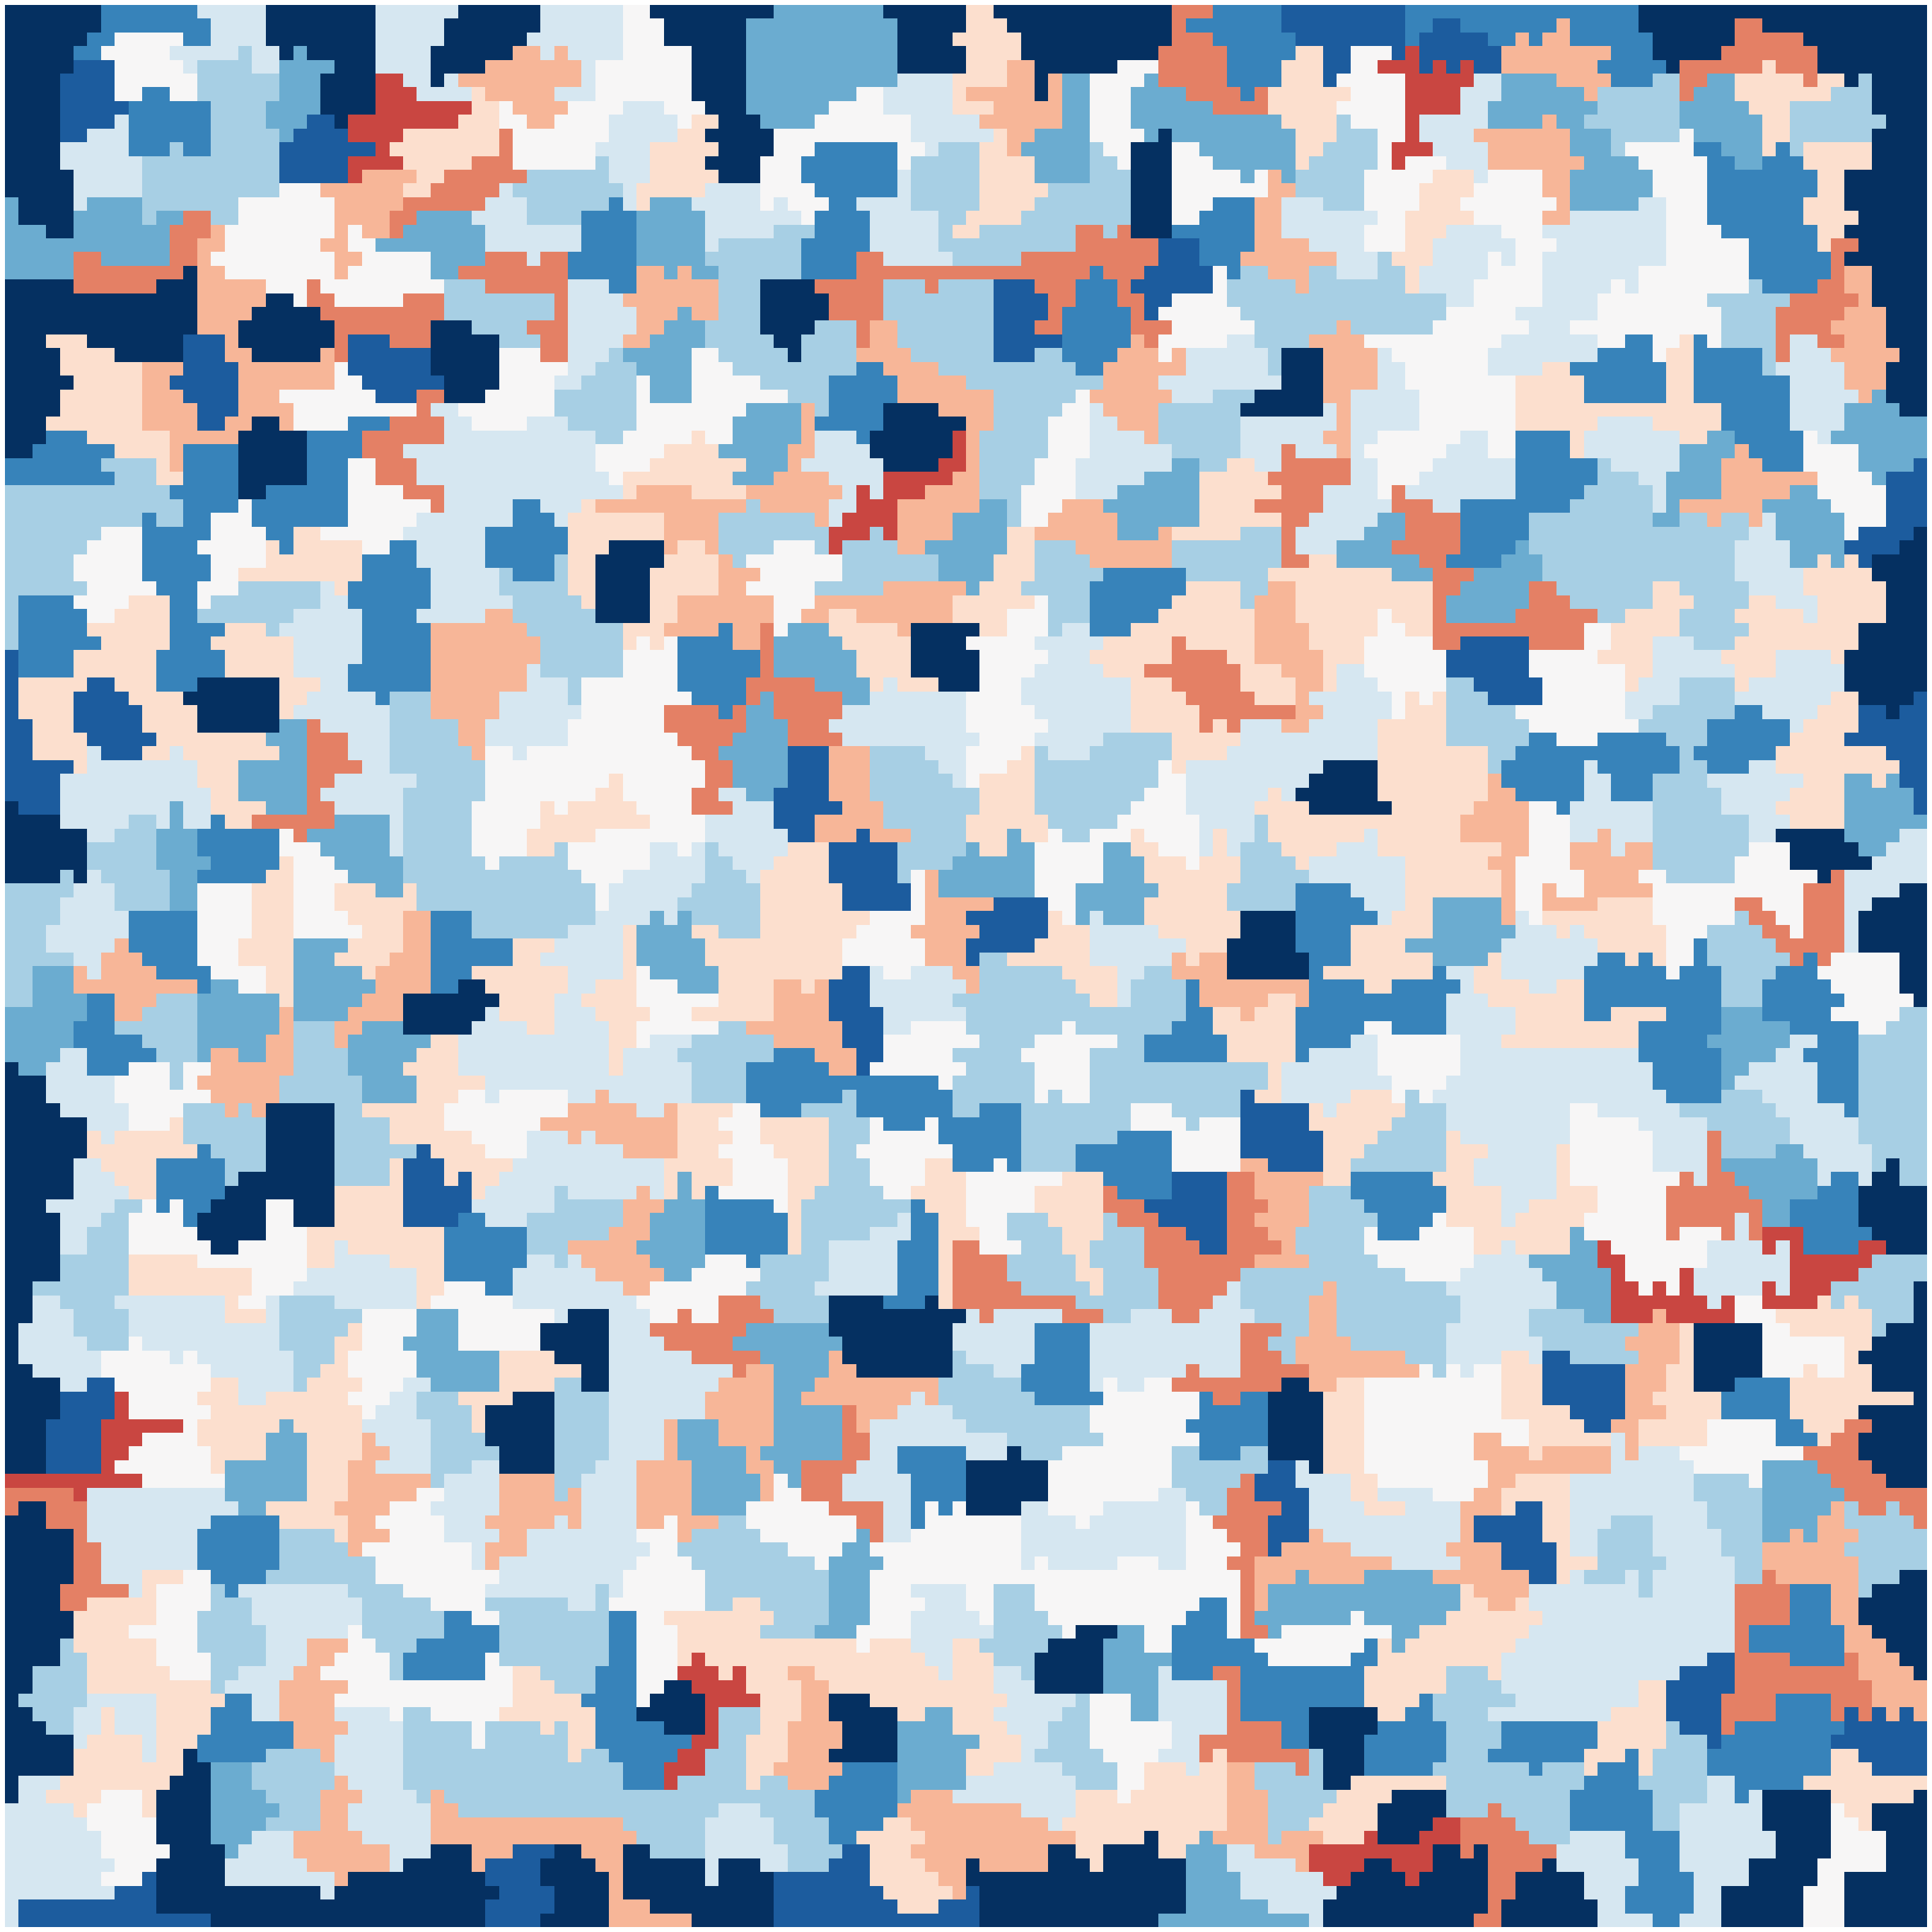

In [78]:
fig, ax = plt.subplots(figsize=(50,50))
ts = 29999
im = heatmap(cellGrid[ts,:,:], cmap = 'RdBu', vmin = np.min(cellGrid[ts,:,:])-2, vmax = np.max(cellGrid[ts,:,:])-15)

In [31]:
cellGrid[ts,:,:].flatten().shape

(19600,)

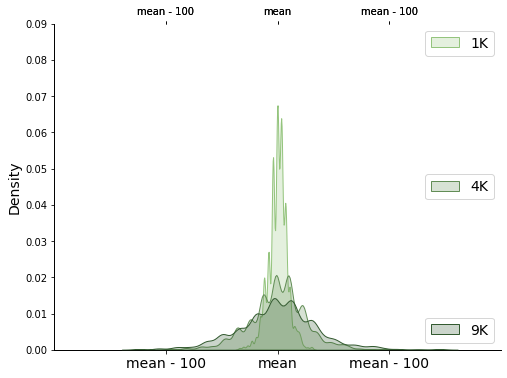

In [288]:
import seaborn as sns

fig1, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twiny()
ax3 = ax1.twiny()
fig1.set_facecolor('white')
fontsize = 14

# ------------------------------------- #

ts1 = 1000
mean_1 = np.mean(cellGrid[ts1,:,:])

# Create a kernel density estimate plot
sns.kdeplot(cellGrid[ts1,:,:].flatten(), ax=ax1, color='#94C47D', fill = True, label = '1K')

# Set x limits and ticks
xlim_min1 = mean_1 - 200
xlim_max1 = mean_1 + 200
ax1.set_xlim([xlim_min1, xlim_max1])
ax1.set_ylim([0, 0.09])
ax1.set_ylabel('Density', fontsize = fontsize)

# Calculate tick positions and labels
tick_vals = np.array([-100, 0, 100])
tick_labels = ['mean - {}'.format(abs(val)) if val != 0 else 'mean' for val in tick_vals]
tick_pos1 = [mean_1 + val for val in tick_vals]

# Set x tick labels and positions
ax1.set_xticks(tick_pos1)
ax1.set_xticklabels(tick_labels, fontsize = fontsize)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ------------------------------------- #

ts2 = 4000
mean_2 = np.mean(cellGrid[ts2,:,:])

# Create a kernel density estimate plot
sns.kdeplot(cellGrid[ts2,:,:].flatten(), ax=ax2, color='#628D56', fill = True, label = '4K')

# Set x limits and ticks
xlim_min2 = mean_2 - 200
xlim_max2 = mean_2 + 200
ax2.set_xlim([xlim_min2, xlim_max2])
ax2.set_ylim([0, 0.09])

# Calculate tick positions and labels
tick_vals = np.array([-100, 0, 100])
tick_labels = ['mean - {}'.format(abs(val)) if val != 0 else 'mean' for val in tick_vals]
tick_pos2 = [mean_2 + val for val in tick_vals]

# Set x tick labels and positions
ax2.set_xticks(tick_pos2)
ax2.set_xticklabels(tick_labels)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ------------------------------------- #

ts3 = 9000
mean_3 = np.mean(cellGrid[ts3,:,:])

# Create a kernel density estimate plot
sns.kdeplot(cellGrid[ts3,:,:].flatten(), ax=ax3, color='#335A30', fill = True, label = '9K')

# Set x limits and ticks
xlim_min3 = mean_3 - 200
xlim_max3 = mean_3 + 200
ax3.set_xlim([xlim_min3, xlim_max3])
ax3.set_ylim([0, 0.09])

# Calculate tick positions and labels
tick_vals = np.array([-100, 0, 100])
tick_labels = ['mean - {}'.format(abs(val)) if val != 0 else 'mean' for val in tick_vals]
tick_pos3 = [mean_3 + val for val in tick_vals]

# Set x tick labels and positions
ax3.set_xticks(tick_pos3)
ax3.set_xticklabels(tick_labels)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# show the plot
ax1.legend(loc = 'upper right', fontsize = fontsize)
ax2.legend(loc = 'center right', fontsize = fontsize)
ax3.legend(loc = 'lower right', fontsize = fontsize)
plt.show()

In [64]:
cellGrid2 = np.zeros((total_ts, Xdim, Ydim))

for ts in np.arange(0, total_ts, 1):
    for x in range(0, Xdim):
        for y in range (0, Ydim):
            cellGrid2[ts, x, y] = int(allNotch[ts, int(allPoints[x, y].id)] - allDelta[ts, int(allPoints[x, y].id)])
        
print(cellGrid.shape)

(30000, 140, 140)


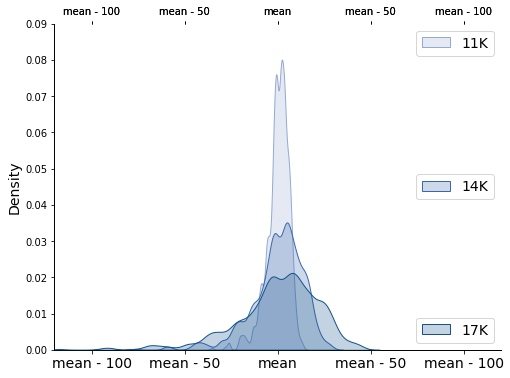

In [254]:
import seaborn as sns

fig1, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twiny()
ax3 = ax1.twiny()
fig1.set_facecolor('white')
fontsize = 14

# ------------------------------------- #

ts1 = 11000
mean_1 = np.mean(cellGrid2[ts1,:,:])

# Create a kernel density estimate plot
sns.kdeplot(cellGrid2[ts1,:,:].flatten(), ax=ax1, color='#95AAD3', fill = True, label = '11K')

# Set x limits and ticks
xlim_min1 = mean_1 - 120
xlim_max1 = mean_1 + 120
ax1.set_xlim([xlim_min1, xlim_max1])
ax1.set_ylim([0, 0.09])
ax1.set_ylabel('Density', fontsize = fontsize)

# Calculate tick positions and labels
tick_vals = np.array([-100, -50, 0, 50, 100])
tick_labels = ['mean - {}'.format(abs(val)) if val != 0 else 'mean' for val in tick_vals]
tick_pos1 = [mean_1 + val for val in tick_vals]

# Set x tick labels and positions
ax1.set_xticks(tick_pos1)
ax1.set_xticklabels(tick_labels, fontsize = fontsize)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# ------------------------------------- #

ts2 = 14000
mean_2 = np.mean(cellGrid2[ts2,:,:])

# Create a kernel density estimate plot
sns.kdeplot(cellGrid2[ts2,:,:].flatten(), ax=ax2, color='#3A68AE', fill = True, label = '14K')

# Set x limits and ticks
xlim_min2 = mean_2 - 120
xlim_max2 = mean_2 + 120
ax2.set_xlim([xlim_min2, xlim_max2])
ax2.set_ylim([0, 0.09])

# Calculate tick positions and labels
tick_vals = np.array([-100, -50, 0, 50, 100])
tick_labels = ['mean - {}'.format(abs(val)) if val != 0 else 'mean' for val in tick_vals]
tick_pos2 = [mean_2 + val for val in tick_vals]

# Set x tick labels and positions
ax2.set_xticks(tick_pos2)
ax2.set_xticklabels(tick_labels)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# ------------------------------------- #

ts3 = 17000
mean_3 = np.mean(cellGrid2[ts3,:,:])

# Create a kernel density estimate plot
sns.kdeplot(cellGrid2[ts3,:,:].flatten(), ax=ax3, color='#155289', fill = True, label = '17K')

# Set x limits and ticks
xlim_min3 = mean_3 - 120
xlim_max3 = mean_3 + 120
ax3.set_xlim([xlim_min3, xlim_max3])
ax3.set_ylim([0, 0.09])

# Calculate tick positions and labels
tick_vals = np.array([-100, -50, 0, 50, 100])
tick_labels = ['mean - {}'.format(abs(val)) if val != 0 else 'mean' for val in tick_vals]
tick_pos3 = [mean_3 + val for val in tick_vals]

# Set x tick labels and positions
ax3.set_xticks(tick_pos3)
ax3.set_xticklabels(tick_labels)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# show the plot
ax1.legend(loc = 'upper right', fontsize = fontsize)
ax2.legend(loc = 'center right', fontsize = fontsize)
ax3.legend(loc = 'lower right', fontsize = fontsize)
plt.show()